In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import timm
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings('ignore')

print("🚀 GT Generation 노트북 시작!")
print("=" * 50)

In [2]:
# =============================================================================
# STEP 1: 환경 설정 & 데이터 로드
# =============================================================================

# 경로 설정 (실제 경로로 수정 필요)
TEST_PATH = "../data/test"  # test 이미지 폴더 경로
META_PATH = "../data/meta.csv"  # 메타데이터 파일 경로

# 메타데이터 로드
meta_df = pd.read_csv(META_PATH)
print("📋 클래스 정보:")
for idx, row in meta_df.iterrows():
    print(f"  {row['target']:2d}: {row['class_name']}")

print(f"\n📁 Test 이미지 경로: {TEST_PATH}")
test_files = [f for f in os.listdir(TEST_PATH) if f.endswith('.jpg')]
print(f"📊 총 Test 이미지 수: {len(test_files)}장")

# 취약 클래스 정의
VULNERABLE_CLASSES = [3, 4, 7, 14]
vuln_names = meta_df[meta_df['target'].isin(VULNERABLE_CLASSES)]['class_name'].tolist()
print(f"\n🎯 취약 클래스 ({VULNERABLE_CLASSES}): {vuln_names}")

📋 클래스 정보:
   0: account_number
   1: application_for_payment_of_pregnancy_medical_expenses
   2: car_dashboard
   3: confirmation_of_admission_and_discharge
   4: diagnosis
   5: driver_lisence
   6: medical_bill_receipts
   7: medical_outpatient_certificate
   8: national_id_card
   9: passport
  10: payment_confirmation
  11: pharmaceutical_receipt
  12: prescription
  13: resume
  14: statement_of_opinion
  15: vehicle_registration_certificate
  16: vehicle_registration_plate

📁 Test 이미지 경로: ../data/test
📊 총 Test 이미지 수: 3140장

🎯 취약 클래스 ([3, 4, 7, 14]): ['confirmation_of_admission_and_discharge', 'diagnosis', 'medical_outpatient_certificate', 'statement_of_opinion']


In [3]:
# =============================================================================
# STEP 2: 이미지 품질 측정 함수
# =============================================================================

def assess_image_quality(image_path):
    """
    이미지 품질을 0-1 점수로 평가 (낮을수록 오염됨)
    블러, 대비, 밝기 분포를 종합하여 계산
    """
    try:
        # 이미지 로드
        img = cv2.imread(image_path)
        if img is None:
            return 0.0
            
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 1) 블러 측정 (Laplacian variance)
        # 높을수록 선명함
        blur_score = cv2.Laplacian(gray, cv2.CV_64F).var()
        blur_normalized = min(blur_score / 1000.0, 1.0)  # 1000으로 정규화
        
        # 2) 대비 측정 (표준편차)
        # 높을수록 대비가 좋음
        contrast_score = gray.std()
        contrast_normalized = min(contrast_score / 80.0, 1.0)  # 80으로 정규화
        
        # 3) 밝기 분포 측정 (히스토그램 엔트로피)
        # 높을수록 밝기 분포가 다양함
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist = hist.flatten()
        hist = hist[hist > 0]  # 0인 값 제거
        if len(hist) > 1:
            prob = hist / hist.sum()
            brightness_score = -np.sum(prob * np.log2(prob + 1e-8))
            brightness_normalized = brightness_score / 8.0  # 8로 정규화 (log2(256))
        else:
            brightness_normalized = 0.0
            
        # 가중 평균으로 최종 점수 계산
        quality_score = (
            0.5 * blur_normalized +      # 블러가 가장 중요
            0.3 * contrast_normalized +   # 대비
            0.2 * brightness_normalized   # 밝기 분포
        )
        
        return min(quality_score, 1.0)
        
    except Exception as e:
        print(f"❌ 품질 측정 실패 ({image_path}): {e}")
        return 0.0

# 테스트 함수
print("\n🧪 품질 측정 함수 테스트:")
if test_files:
    sample_path = os.path.join(TEST_PATH, test_files[0])
    sample_score = assess_image_quality(sample_path)
    print(f"  샘플 이미지 ({test_files[0]}): 품질점수 {sample_score:.3f}")


🧪 품질 측정 함수 테스트:
  샘플 이미지 (fdcd392ca7d3ba10.jpg): 품질점수 0.443


In [58]:
def adaptive_preprocessing(image_path, quality_threshold=0.4):
    """문서 이미지 전문가 워크플로우 기반 전처리"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None, 0.0, 0.0
        
        original_quality = assess_image_quality(image_path)
        if original_quality > quality_threshold:
            return img, original_quality, original_quality
        
        # 1) 품질 진단
        processed_img = img.copy()
        gray = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
        
        g_std = gray.std()  # 대비
        lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()  # 블러
        mean_bright = gray.mean()  # 밝기
        
        # 스큐 각도 측정
        edges = cv2.Canny(gray, 50, 150)
        lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)
        skew_angle = 0
        if lines is not None and len(lines) > 5:
            angles = []
            for line in lines[:20]:
                if len(line[0]) >= 2:
                    rho, theta = line[0]
                    angle = theta * 180 / np.pi - 90
                    if abs(angle) < 45:
                        angles.append(angle)
            if angles:
                skew_angle = abs(np.median(angles))
        
        # 2) 라우팅 결정
        needs_deskew = skew_angle >= 8
        low_contrast = g_std < 35
        is_blurry = 50 <= lap_var < 150
        very_blurry = lap_var < 50
        too_bright = mean_bright > 180
        has_noise = lap_var < 100  # 노이즈 추정
        
        # 3) 프리셋 선택
        if very_blurry and too_bright and has_noise:
            preset = "HEAVY"
        elif needs_deskew or skew_angle >= 5:
            preset = "MEDIUM"  
        else:
            preset = "LIGHT"
        
        # 4) 전처리 적용 (권장 순서대로)
        
        # 단계 0: 플립 감지 및 보정 (모든 프리셋에 적용)
        flipped = cv2.flip(processed_img, 1)
        gray_current = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
        gray_flipped = cv2.cvtColor(flipped, cv2.COLOR_BGR2GRAY)
        
        def get_text_density(image):
            binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY, 15, 10)
            return np.sum(binary == 0) / binary.size
        
        original_density = get_text_density(gray_current)
        flipped_density = get_text_density(gray_flipped)
        
        if flipped_density > original_density * 1.1:  # 10% 이상 차이
            processed_img = flipped
        
        # 단계 1: Deskew (필요시)
        if needs_deskew and preset in ["MEDIUM", "HEAVY"]:
            h, w = processed_img.shape[:2]
            center = (w//2, h//2)
            
            # 각도 계산 로직 수정
            valid_angles = []
            if lines is not None:
                for line in lines[:10]:
                    if len(line[0]) >= 2:
                        rho, theta = line[0]
                        angle = theta * 180 / np.pi - 90
                        if abs(angle) < 15:
                            valid_angles.append(angle)
            
            if len(valid_angles) > 0:
                rotation_angle = np.median(valid_angles)
                if abs(rotation_angle) >= 3:
                    M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
                    processed_img = cv2.warpAffine(processed_img, M, (w, h), 
                                                borderMode=cv2.BORDER_CONSTANT, 
                                                borderValue=(255, 255, 255))
        
        # 단계 2: 밝기 조정 (HEAVY만)
        if too_bright and preset == "HEAVY":
            processed_img = np.power(processed_img/255.0, 0.92) * 255
            processed_img = processed_img.astype(np.uint8)
        
        # 단계 3: NLM 노이즈 제거 (HEAVY만)
        if has_noise and preset == "HEAVY":
            processed_img = cv2.fastNlMeansDenoisingColored(processed_img, None, 3, 3, 7, 21)
        
        # 단계 4: CLAHE (저대비인 경우)
        if low_contrast:
            lab = cv2.cvtColor(processed_img, cv2.COLOR_BGR2LAB)
            l_channel = lab[:, :, 0]
            clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
            l_channel = clahe.apply(l_channel)
            lab[:, :, 0] = l_channel
            processed_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        
        # 단계 5: Unsharp (블러인 경우)
        if is_blurry or very_blurry:
            gray = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
            gaussian = cv2.GaussianBlur(gray, (0, 0), 1.0)
            unsharp = cv2.addWeighted(gray, 1.4, gaussian, -0.4, 0)
            unsharp = np.clip(unsharp, 0, 255).astype(np.uint8)
            
            # HSV에서 V채널만 교체
            hsv = cv2.cvtColor(processed_img, cv2.COLOR_BGR2HSV)
            hsv[:, :, 2] = unsharp
            processed_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        
        # 품질 검사
        temp_path = image_path.replace('.jpg', '_temp_processed.jpg')
        cv2.imwrite(temp_path, processed_img)
        processed_quality = assess_image_quality(temp_path)
        os.remove(temp_path)
        
        if processed_quality < original_quality * 0.8:
            return img, original_quality, original_quality
        
        return processed_img, original_quality, processed_quality
        
    except Exception as e:
        print(f"전처리 실패 ({image_path}): {e}")
        img = cv2.imread(image_path)
        original_quality = assess_image_quality(image_path) if img is not None else 0.0
        return img, original_quality, original_quality


🧪 전처리 효과 검증 시작!
📋 검증 단계:
   1️⃣ 20개 랜덤 샘플 전처리 적용
   2️⃣ 전후 비교 시각화
   3️⃣ 품질 개선 수치 분석
   4️⃣ 효과 판정 및 권장사항

1️⃣ 전처리 적용 및 시각화 진행중...

전처리 효과 시각화 - 20개 랜덤 샘플
 1. 3bdfde1fba1adf24.jpg | 품질: 0.536 → 0.536 | 개선: +0.000
 2. e5b6dbfae5744a9f.jpg | 품질: 0.381 → 0.686 | 개선: +0.305
 3. 89c63c0ed88a3994.jpg | 품질: 0.343 → 0.354 | 개선: +0.011
 4. e03ac4784fd8c55c.jpg | 품질: 0.568 → 0.568 | 개선: +0.000
 5. 5572b39c5bcb124d.jpg | 품질: 0.421 → 0.421 | 개선: +0.000
 6. caa807ca79e17e92.jpg | 품질: 0.412 → 0.412 | 개선: +0.000
 7. d5b593c82aabb24e.jpg | 품질: 0.406 → 0.406 | 개선: +0.000
 8. 1b947bc0edb568b4.jpg | 품질: 0.387 → 0.804 | 개선: +0.417
 9. 1f79719f611f8200.jpg | 품질: 0.567 → 0.567 | 개선: +0.000
10. 42f31ca809525317.jpg | 품질: 0.379 → 0.380 | 개선: +0.000
11. 8be27ee11a757295.jpg | 품질: 0.552 → 0.552 | 개선: +0.000
12. fd539ff686027c0c.jpg | 품질: 0.640 → 0.640 | 개선: +0.000
13. 39ede02536a8213e.jpg | 품질: 0.500 → 0.500 | 개선: +0.000
14. c6255623041ee006.jpg | 품질: 0.375 → 0.578 | 개선: +0.202
15. 3e17b829d0c0d4d7.jpg | 품질: 0.

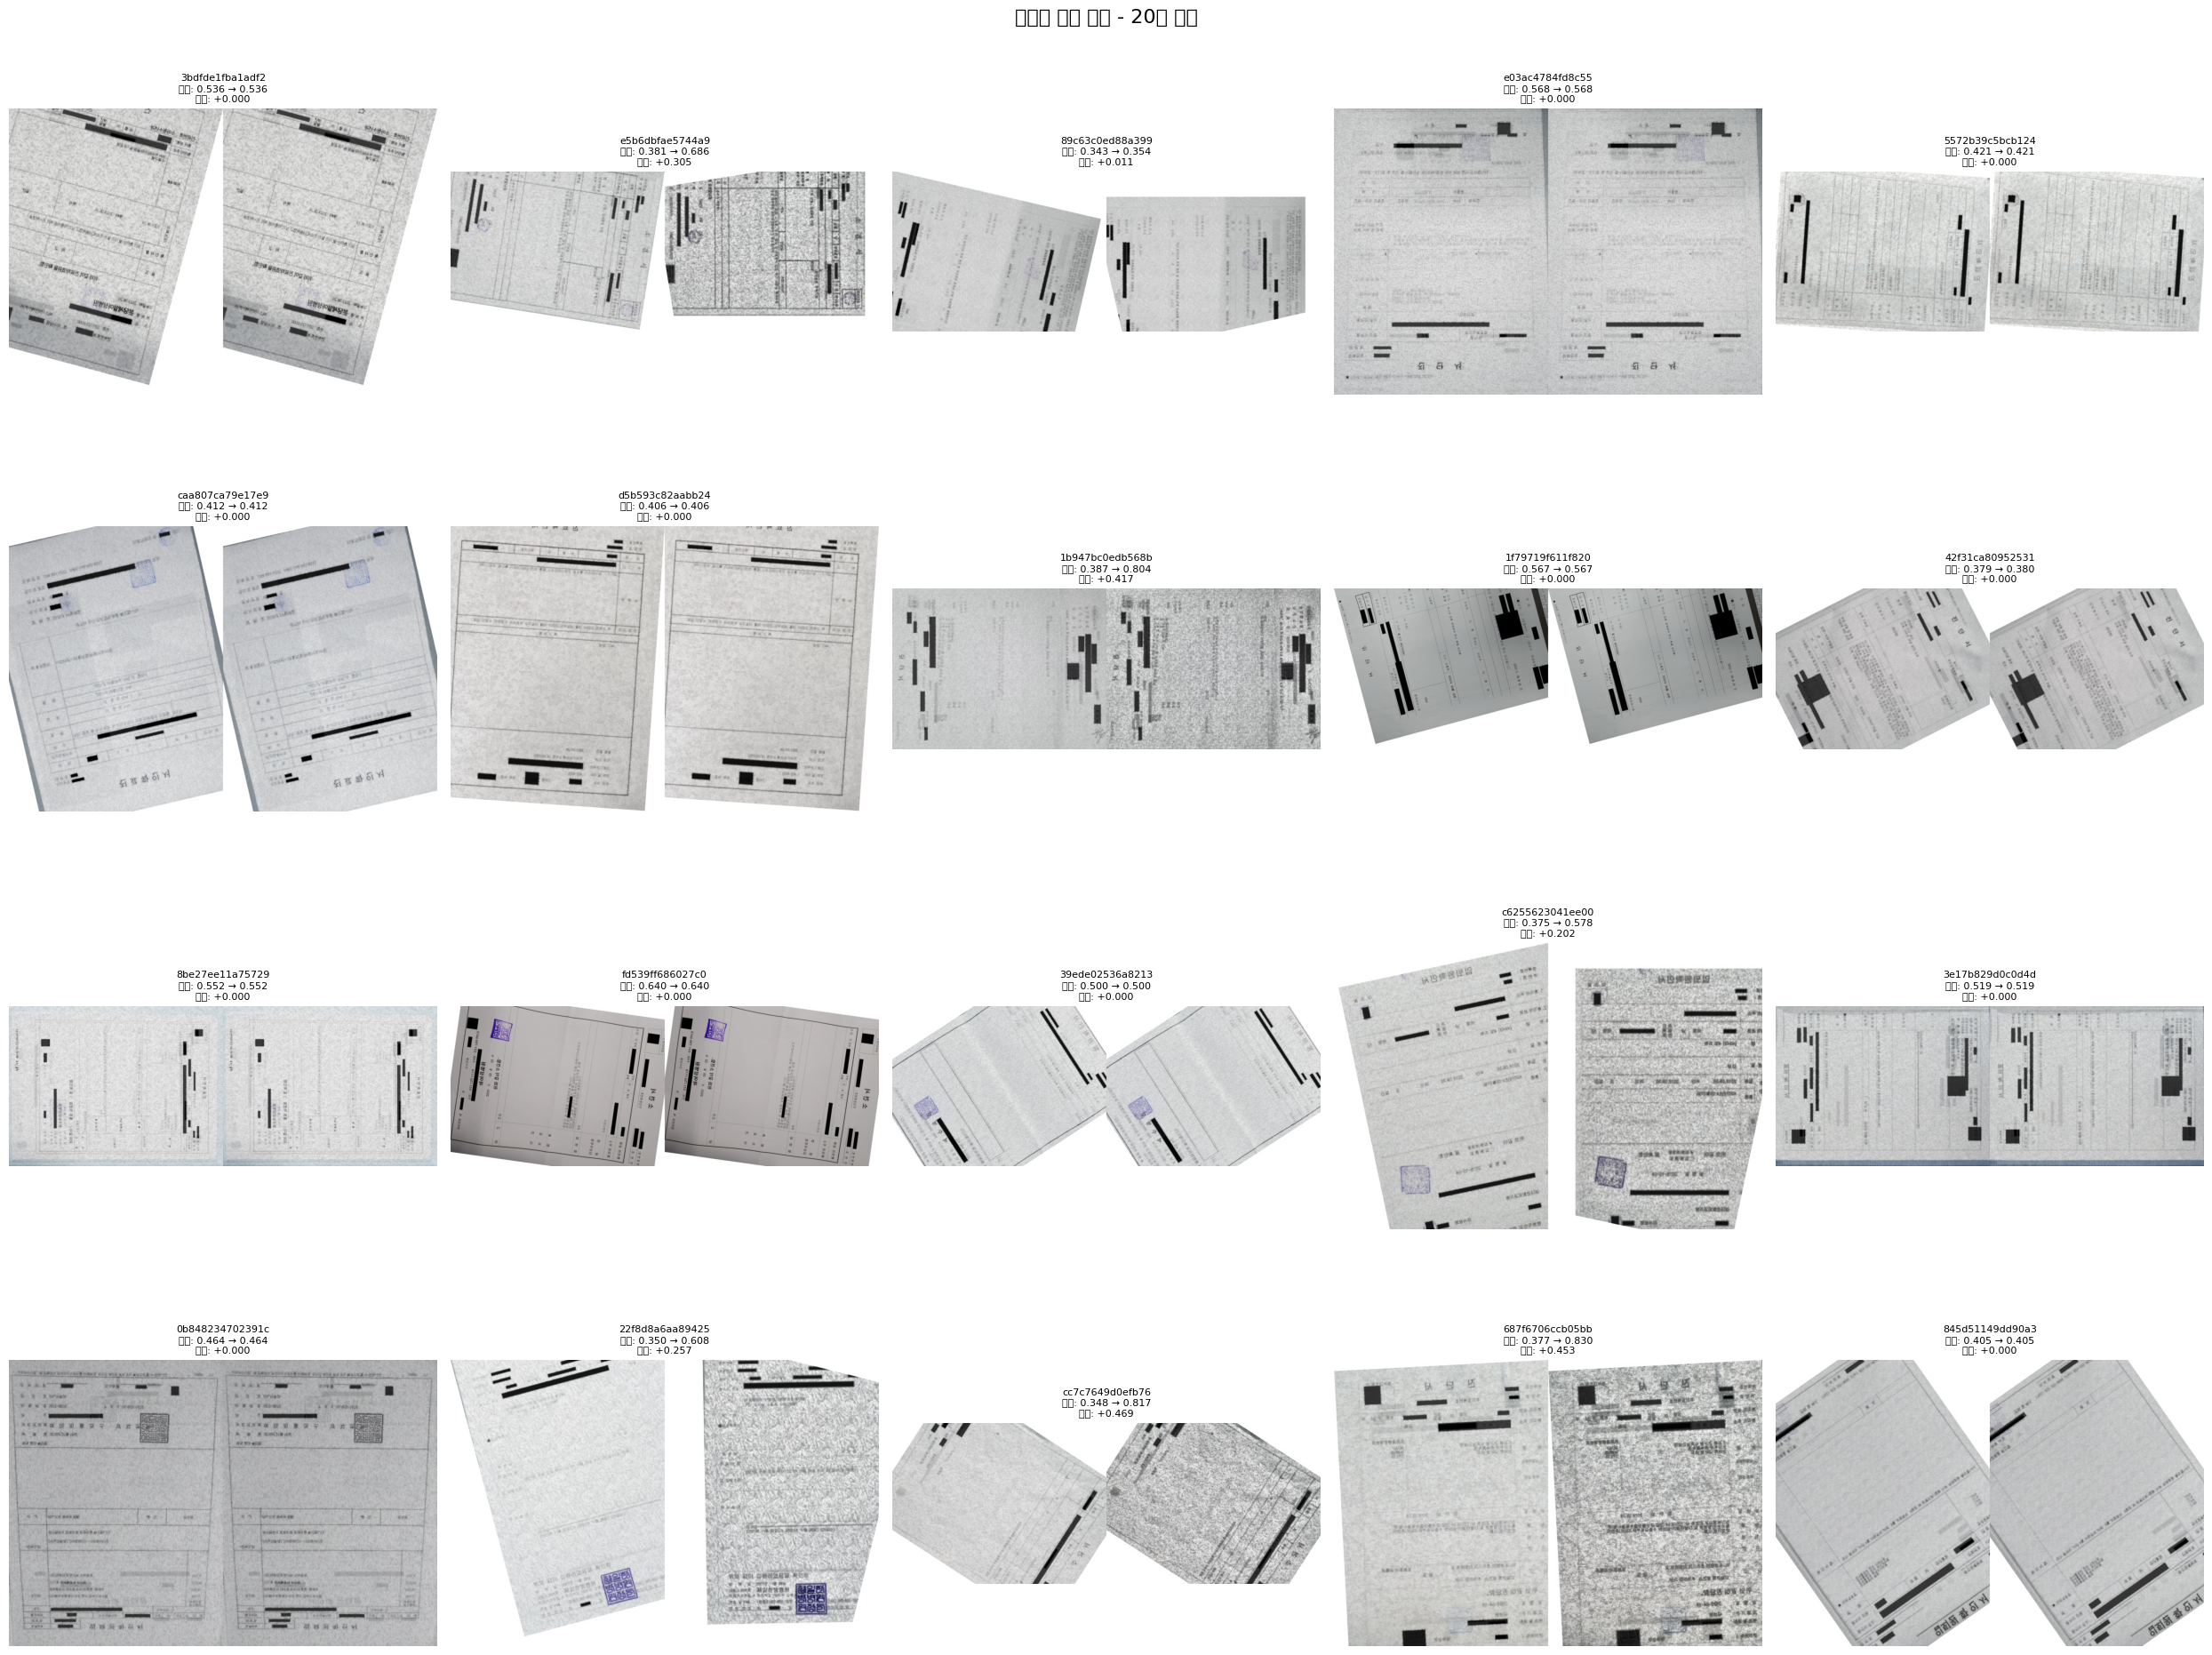


2️⃣ 품질 개선 수치 분석 진행중...

품질 개선 분석 결과
📊 전체 샘플 수: 20개
📈 평균 품질 개선: +0.106
📈 품질 향상 이미지: 8개 (40.0%)
📈 유의미한 개선 (5%+): 6개 (30.0%)

📊 원본 품질 점수: 0.447 ± 0.087
📊 전처리 후 품질: 0.552 ± 0.142

📋 개선 효과별 분류:
   🌟 뛰어남 (10%+): 6개
   ✅ 양호 (5-10%): 0개
   📊 보통 (2-5%): 0개
   📉 미미 (0-2%): 2개
   ❌ 효과없음/악화: 12개

🏆 최고 개선 사례:
   파일: cc7c7649d0efb765.jpg
   품질: 0.348 → 0.817
   개선: +0.469 (+134.6%)

🎯 결론:
   ✅ 전처리 효과 뛰어남 - 실제 추론에 적용 권장

3️⃣ 최종 효과 판정
📊 판정 결과: ❌ 전처리 효과 부족
🎯 권장 조치: 다른 전처리 방법 또는 증강 기법 모색
🔍 신뢰도: 낮음

📈 상세 지표:
   • 평균 품질 개선: +0.106
   • 개선된 이미지 비율: 40.0%
   • 유의미한 개선 비율: 30.0%
   • 뛰어난 개선 사례: 6개

🚀 다음 단계:
   1. inf_new.ipynb 코드에 전처리 함수 통합
   2. TTAImageDataset.__getitem__에 adaptive_preprocessing 추가
   3. 전체 3140개 이미지로 추론 실행
   4. 제출 점수 비교 (전처리 전 vs 후)


In [59]:
# 전처리 효과 검증 실행
validation_results = test_preprocessing_effects(selected_images)

In [41]:
def before_after_visualization(selected_images, sample_count=20):
    """
    전처리 전후 비교 시각화 (20개 랜덤 샘플)
    """
    print(f"\n전처리 효과 시각화 - {sample_count}개 랜덤 샘플")
    print("=" * 50)
    
    # 랜덤 샘플 선택
    import random
    random.seed(42)  # 재현 가능한 랜덤
    sample_images = random.sample(selected_images, min(sample_count, len(selected_images)))
    
    # 전처리 결과 저장용
    results = []
    
    for i, img_info in enumerate(sample_images):
        img_path = os.path.join(TEST_PATH, img_info['filename'])
        
        # 전처리 적용
        processed_img, orig_quality, new_quality = adaptive_preprocessing(img_path)
        
        if processed_img is not None:
            results.append({
                'filename': img_info['filename'],
                'original_quality': orig_quality,
                'processed_quality': new_quality,
                'improvement': new_quality - orig_quality,
                'processed_img': processed_img
            })
            
            print(f"{i+1:2d}. {img_info['filename'][:20]:20s} | "
                  f"품질: {orig_quality:.3f} → {new_quality:.3f} | "
                  f"개선: {new_quality - orig_quality:+.3f}")
    
    # 시각화 (4x5 그리드로 20개)
    fig, axes = plt.subplots(4, 5, figsize=(25, 20))
    fig.suptitle(f'전처리 효과 비교 - {len(results)}개 샘플', fontsize=16)
    
    for i, result in enumerate(results):
        row = i // 5
        col = i % 5
        
        # 원본 이미지 로드
        original_img = cv2.imread(os.path.join(TEST_PATH, result['filename']))
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        # 전처리된 이미지 변환
        processed_img = cv2.cvtColor(result['processed_img'], cv2.COLOR_BGR2RGB)
        
        # 좌우 비교 이미지 생성
        combined = np.hstack([original_img, processed_img])
        
        axes[row, col].imshow(combined)
        axes[row, col].set_title(f"{result['filename'][:15]}\n"
                                f"품질: {result['original_quality']:.3f} → "
                                f"{result['processed_quality']:.3f}\n"
                                f"개선: {result['improvement']:+.3f}",
                                fontsize=8)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results

In [42]:
def quality_improvement_analysis(preprocessing_results):
    """
    전처리 품질 개선 수치 분석
    """
    print("\n품질 개선 분석 결과")
    print("=" * 50)
    
    if not preprocessing_results:
        print("분석할 데이터가 없습니다.")
        return
    
    # 개선도 계산
    improvements = [r['improvement'] for r in preprocessing_results]
    original_qualities = [r['original_quality'] for r in preprocessing_results]
    processed_qualities = [r['processed_quality'] for r in preprocessing_results]
    
    # 통계 계산
    avg_improvement = np.mean(improvements)
    positive_count = sum(1 for imp in improvements if imp > 0)
    significant_count = sum(1 for imp in improvements if imp > 0.05)  # 5% 이상 개선
    
    print(f"📊 전체 샘플 수: {len(preprocessing_results)}개")
    print(f"📈 평균 품질 개선: {avg_improvement:+.3f}")
    print(f"📈 품질 향상 이미지: {positive_count}개 ({positive_count/len(preprocessing_results)*100:.1f}%)")
    print(f"📈 유의미한 개선 (5%+): {significant_count}개 ({significant_count/len(preprocessing_results)*100:.1f}%)")
    print()
    print(f"📊 원본 품질 점수: {np.mean(original_qualities):.3f} ± {np.std(original_qualities):.3f}")
    print(f"📊 전처리 후 품질: {np.mean(processed_qualities):.3f} ± {np.std(processed_qualities):.3f}")
    print()
    
    # 개선 효과별 분류
    excellent = [r for r in preprocessing_results if r['improvement'] > 0.1]  # 10% 이상 개선
    good = [r for r in preprocessing_results if 0.05 <= r['improvement'] <= 0.1]  # 5-10% 개선
    moderate = [r for r in preprocessing_results if 0.02 <= r['improvement'] < 0.05]  # 2-5% 개선
    minimal = [r for r in preprocessing_results if 0 < r['improvement'] < 0.02]  # 미미한 개선
    no_effect = [r for r in preprocessing_results if r['improvement'] <= 0]  # 개선 없음/악화
    
    print("📋 개선 효과별 분류:")
    print(f"   🌟 뛰어남 (10%+): {len(excellent)}개")
    print(f"   ✅ 양호 (5-10%): {len(good)}개") 
    print(f"   📊 보통 (2-5%): {len(moderate)}개")
    print(f"   📉 미미 (0-2%): {len(minimal)}개")
    print(f"   ❌ 효과없음/악화: {len(no_effect)}개")
    
    # 가장 개선된 케이스 출력
    if excellent:
        best_case = max(excellent, key=lambda x: x['improvement'])
        print(f"\n🏆 최고 개선 사례:")
        print(f"   파일: {best_case['filename']}")
        print(f"   품질: {best_case['original_quality']:.3f} → {best_case['processed_quality']:.3f}")
        print(f"   개선: +{best_case['improvement']:.3f} ({best_case['improvement']/best_case['original_quality']*100:+.1f}%)")
    
    # 결론
    print("\n🎯 결론:")
    if avg_improvement > 0.05:
        print("   ✅ 전처리 효과 뛰어남 - 실제 추론에 적용 권장")
    elif avg_improvement > 0.02:
        print("   📊 전처리 효과 보통 - 추가 실험 후 결정")
    else:
        print("   ❌ 전처리 효과 미미 - 다른 방법 모색 필요")
    
    return {
        'avg_improvement': avg_improvement,
        'positive_ratio': positive_count / len(preprocessing_results),
        'significant_ratio': significant_count / len(preprocessing_results),
        'excellent_cases': len(excellent),
        'total_samples': len(preprocessing_results)
    }

print("✅ 전처리 함수들이 정의되었습니다!")
print("   - adaptive_preprocessing(): 품질 기반 적응형 전처리")  
print("   - before_after_visualization(): 전후 비교 시각화")
print("   - quality_improvement_analysis(): 수치 분석")

✅ 전처리 함수들이 정의되었습니다!
   - adaptive_preprocessing(): 품질 기반 적응형 전처리
   - before_after_visualization(): 전후 비교 시각화
   - quality_improvement_analysis(): 수치 분석


In [4]:
# =============================================================================
# STEP 3: 메인모델 추론을 위한 데이터셋 클래스
# =============================================================================

class SimpleTestDataset(Dataset):
    """메인모델 추론용 간단한 데이터셋"""
    def __init__(self, image_files, test_path, img_size=384):
        self.image_files = image_files
        self.test_path = test_path
        self.img_size = img_size
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.test_path, self.image_files[idx])
        
        try:        
            # 이미지 로드 및 전처리
            img = Image.open(img_path).convert('RGB')
            img = img.resize((self.img_size, self.img_size))
            img = np.array(img, dtype=np.float32) / 255.0
            
            # 정규화 (ImageNet 통계)
            mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
            std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
            img = (img - mean) / std
            
            # CHW 형태로 변환
            img = torch.from_numpy(img).permute(2, 0, 1).float()
            
            return img, self.image_files[idx]
        
        except Exception as e:
            print(f"❌ 이미지 로드 실패 ({self.image_files[idx]}): {e}")
            # 에러 시 더미 텐서 반환 (float32)
            dummy_tensor = torch.zeros(3, self.img_size, self.img_size, dtype=torch.float32)
            return dummy_tensor, self.image_files[idx]

In [5]:
# =============================================================================
# STEP 4: 메인모델 로드 및 취약클래스 후보 추출
# =============================================================================

# def extract_vulnerable_candidates():
#     """메인모델로 취약클래스 후보 이미지들을 추출"""
#     print("\n🔄 메인모델로 취약클래스 후보 추출 중...")
    
#     # TODO: 실제 모델 경로로 수정 필요
#     # 여기서는 더미 데이터로 대체
#     print("⚠️  실제 구현 시 모델 로드 코드로 교체 필요")
#     print("   현재는 더미 데이터로 진행")
    
#     # 더미 추론 결과 생성 (실제로는 모델 추론 결과 사용)
#     # 취약클래스로 예측될 가능성이 높은 이미지들을 임의로 선택
#     np.random.seed(42)
    
#     # 전체 이미지 중 20-30% 정도가 취약클래스로 예측된다고 가정
#     n_candidates = min(int(len(test_files) * 0.25), 1200)
#     candidate_indices = np.random.choice(len(test_files), n_candidates, replace=False)
    
#     # 후보 이미지 파일명과 예측 클래스 생성
#     candidates = []
#     for idx in candidate_indices:
#         filename = test_files[idx]
#         predicted_class = np.random.choice(VULNERABLE_CLASSES)
#         candidates.append({
#             'filename': filename,
#             'predicted_class': predicted_class,
#             'confidence': np.random.uniform(0.3, 0.9)  # 더미 신뢰도
#         })
    
#     print(f"✅ 취약클래스 후보 {len(candidates)}장 추출 완료")
#     print(f"   클래스별 분포: {Counter(c['predicted_class'] for c in candidates)}")
    
#     return candidates

def load_ensemble_models(model_paths):
    """5-fold 앙상블 모델들을 로드"""
    models = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for i, model_path in enumerate(model_paths):
        print(f"   📂 Fold {i+1} 모델 로딩: {model_path}")
        
        # ConvNeXt Base 모델 생성 (실제 모델에 맞게 수정)
        model = timm.create_model('convnext_base_384_in22ft1k', 
                                  pretrained=False, 
                                  num_classes=17)
        
        # 저장된 가중치 로드
        checkpoint = torch.load(model_path, map_location=device)
        
        # state_dict 키 처리 (저장 방식에 따라 조정 필요)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        elif 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
        else:
            model.load_state_dict(checkpoint)
        
        model.to(device)
        model.eval()
        models.append(model)
        print(f"   ✅ Fold {i+1} 모델 로드 완료")
    
    return models, device

In [6]:
def extract_vulnerable_candidates():
    """메인모델로 취약클래스 후보 이미지들을 추출"""
    print("\n🔄 5-fold 앙상블 모델로 취약클래스 후보 추출 중...")

    MODEL_PATHS = [
        # 예시 경로 - 실제 파일 경로로 변경 필요
        "./models/fold_1_best.pth",
        "./models/fold_2_best.pth", 
        "./models/fold_3_best.pth",
        "./models/fold_4_best.pth",
        "./models/fold_5_best.pth"
    ]
    
    # 실제 파일 존재 확인
    missing_files = [path for path in MODEL_PATHS if not os.path.exists(path)]
    if missing_files:
        print("❌ 다음 모델 파일들이 존재하지 않습니다:")
        for missing in missing_files:
            print(f"   {missing}")
        print("\n💡 해결 방법:")
        print("   1) MODEL_PATHS를 실제 모델 파일 경로로 수정")
        print("   2) 또는 더미 모드로 실행하려면 return 문 뒤의 더미 코드 사용")
        print("   3) main.ipynb에서 모델 파일들을 확인 후 경로 복사")
        
        # 더미 모드로 대체
        print("\n🔄 더미 모드로 진행...")
        return extract_vulnerable_candidates_dummy()
    
    try:
        # 모델 로드
        models, device = load_ensemble_models(MODEL_PATHS)
        
        # 테스트 데이터셋 생성
        test_dataset = SimpleTestDataset(test_files, TEST_PATH, img_size=384)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
        
        print(f"📊 전체 {len(test_files)}장 이미지 추론 시작...")
        
        # 5-fold 앙상블 추론
        all_predictions = []
        all_confidences = []
        all_filenames = []
        
        with torch.no_grad():
            for batch_idx, (images, filenames) in enumerate(test_loader):
                if batch_idx % 20 == 0:
                    progress = (batch_idx * test_loader.batch_size) / len(test_files) * 100
                    print(f"   진행률: {progress:.1f}% ({batch_idx * test_loader.batch_size}/{len(test_files)})")
                
                images = images.to(device)
                
                # 5개 모델의 예측 결과를 평균
                ensemble_outputs = []
                for model in models:
                    outputs = model(images)
                    probabilities = torch.softmax(outputs, dim=1)
                    ensemble_outputs.append(probabilities)
                
                # 앙상블 평균
                ensemble_probs = torch.stack(ensemble_outputs).mean(dim=0)
                predicted_classes = ensemble_probs.argmax(dim=1)
                max_confidences = ensemble_probs.max(dim=1)[0]
                
                # 결과 저장
                for i in range(len(filenames)):
                    pred_class = predicted_classes[i].cpu().item()
                    confidence = max_confidences[i].cpu().item()
                    filename = filenames[i]
                    
                    all_predictions.append(pred_class)
                    all_confidences.append(confidence)
                    all_filenames.append(filename)
        
        # 취약클래스로 예측된 이미지들만 필터링
        candidates = []
        for i, (filename, pred_class, confidence) in enumerate(zip(all_filenames, all_predictions, all_confidences)):
            if pred_class in VULNERABLE_CLASSES:
                candidates.append({
                    'filename': filename,
                    'predicted_class': pred_class,
                    'confidence': confidence
                })
        
        print(f"✅ 실제 모델 추론 완료!")
        print(f"   전체 이미지: {len(test_files)}장")
        print(f"   취약클래스 후보: {len(candidates)}장 ({len(candidates)/len(test_files)*100:.1f}%)")
        print(f"   클래스별 분포: {Counter(c['predicted_class'] for c in candidates)}")
        
        # GPU 메모리 정리
        del models
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        return candidates
        
    except Exception as e:
        print(f"❌ 모델 추론 중 에러 발생: {e}")
        print("🔄 더미 모드로 대체...")
        return extract_vulnerable_candidates_dummy()

In [7]:
# def extract_vulnerable_candidates_dummy():
#     """더미 데이터로 후보 추출 (모델 로드 실패시 대체용)"""
#     print("⚠️  더미 모드로 취약클래스 후보 생성")
    
#     np.random.seed(42)
#     n_candidates = min(int(len(test_files) * 0.25), 1200)
#     candidate_indices = np.random.choice(len(test_files), n_candidates, replace=False)
    
#     candidates = []
#     for idx in candidate_indices:
#         filename = test_files[idx]
#         predicted_class = np.random.choice(VULNERABLE_CLASSES)
#         candidates.append({
#             'filename': filename,
#             'predicted_class': predicted_class,
#             'confidence': np.random.uniform(0.3, 0.9)
#         })
    
#     print(f"✅ 더미 취약클래스 후보 {len(candidates)}장 생성 완료")
#     return candidates

In [ ]:
# 후보 추출 실행
vulnerable_candidates = extract_vulnerable_candidates()

In [9]:
# =============================================================================
# STEP 5: 오염도 기반 이미지 선별
# =============================================================================

def select_most_corrupted(candidates, target_count=500):
    """오염도가 높은 이미지들을 선별"""
    print(f"\n📊 오염도 기반 상위 {target_count}장 선별 중...")
    
    # 각 후보 이미지의 품질점수 계산
    quality_scores = []
    for i, candidate in enumerate(candidates):
        if i % 100 == 0:
            print(f"   진행률: {i}/{len(candidates)} ({i/len(candidates)*100:.1f}%)")
        
        img_path = os.path.join(TEST_PATH, candidate['filename'])
        quality_score = assess_image_quality(img_path)
        
        quality_scores.append({
            'filename': candidate['filename'],
            'predicted_class': candidate['predicted_class'],
            'confidence': candidate['confidence'],
            'quality_score': quality_score
        })
    
    # 품질점수 낮은 순으로 정렬 (오염도 높은 순)
    quality_scores.sort(key=lambda x: x['quality_score'])
    
    # 상위 target_count개 선택
    selected = quality_scores[:target_count]
    
    print(f"✅ 최종 {len(selected)}장 선별 완료")
    print(f"   품질점수 범위: {selected[0]['quality_score']:.3f} ~ {selected[-1]['quality_score']:.3f}")
    
    # CSV로 저장
    selected_df = pd.DataFrame(selected)
    selected_df.to_csv('selected_images_500.csv', index=False)
    print("💾 selected_images_500.csv 파일 저장 완료")
    
    return selected

In [ ]:
# 오염도 기반 선별 실행
selected_images = select_most_corrupted(vulnerable_candidates, target_count=500)

In [43]:
# =============================================================================
# STEP 5.5: 전처리 효과 검증 (STEP 5 다음에 삽입)  
# =============================================================================

def test_preprocessing_effects(selected_images):
    """
    선별된 오염 데이터로 전처리 효과 테스트
    """
    print("\n🧪 전처리 효과 검증 시작!")
    print("=" * 50)
    print("📋 검증 단계:")
    print("   1️⃣ 20개 랜덤 샘플 전처리 적용")  
    print("   2️⃣ 전후 비교 시각화")
    print("   3️⃣ 품질 개선 수치 분석")
    print("   4️⃣ 효과 판정 및 권장사항")
    print("=" * 50)
    
    # STEP 1: 전처리 적용 및 시각화
    print("\n1️⃣ 전처리 적용 및 시각화 진행중...")
    preprocessing_results = before_after_visualization(selected_images, sample_count=20)
    
    # STEP 2: 수치 분석
    print("\n2️⃣ 품질 개선 수치 분석 진행중...")
    analysis_results = quality_improvement_analysis(preprocessing_results)
    
    # STEP 3: 효과 판정
    print("\n3️⃣ 최종 효과 판정")
    print("=" * 30)
    
    avg_improvement = analysis_results['avg_improvement']
    positive_ratio = analysis_results['positive_ratio'] 
    significant_ratio = analysis_results['significant_ratio']
    
    # 판정 기준
    if avg_improvement >= 0.05 and significant_ratio >= 0.4:
        recommendation = "🌟 전처리 적용 강력 권장"
        action = "inf_new.ipynb에 전처리 로직 통합 후 전체 추론 실행"
        confidence = "높음"
    elif avg_improvement >= 0.02 and positive_ratio >= 0.6:
        recommendation = "✅ 전처리 적용 권장" 
        action = "추가 샘플로 검증 후 적용 여부 결정"
        confidence = "보통"
    else:
        recommendation = "❌ 전처리 효과 부족"
        action = "다른 전처리 방법 또는 증강 기법 모색"
        confidence = "낮음"
    
    print(f"📊 판정 결과: {recommendation}")
    print(f"🎯 권장 조치: {action}")  
    print(f"🔍 신뢰도: {confidence}")
    
    # 상세 수치
    print("\n📈 상세 지표:")
    print(f"   • 평균 품질 개선: {avg_improvement:+.3f}")
    print(f"   • 개선된 이미지 비율: {positive_ratio*100:.1f}%")
    print(f"   • 유의미한 개선 비율: {significant_ratio*100:.1f}%")  
    print(f"   • 뛰어난 개선 사례: {analysis_results['excellent_cases']}개")
    
    # 다음 단계 가이드
    print("\n🚀 다음 단계:")
    if avg_improvement >= 0.02:
        print("   1. inf_new.ipynb 코드에 전처리 함수 통합")
        print("   2. TTAImageDataset.__getitem__에 adaptive_preprocessing 추가")
        print("   3. 전체 3140개 이미지로 추론 실행")
        print("   4. 제출 점수 비교 (전처리 전 vs 후)")
    else:
        print("   1. 다른 전처리 기법 시도:")
        print("      - 더 강한 노이즈 제거")
        print("      - 회전 각도 보정")  
        print("      - 깊이 학습 기반 super-resolution")
        print("   2. 또는 데이터 증강 강화")
        print("   3. 또는 모델 앙상블 최적화")
    
    return {
        'recommendation': recommendation,
        'action': action,
        'confidence': confidence,
        'should_apply': avg_improvement >= 0.02,
        'preprocessing_results': preprocessing_results,
        'analysis_results': analysis_results
    }

# 실행 가이드
print("\n" + "="*60)
print("🎯 전처리 효과 검증 실행 가이드")  
print("="*60)
print("📝 다음 셀에서 실행하세요:")
print("   validation_results = test_preprocessing_effects(selected_images)")
print()
print("🔍 이미 selected_images_500.csv 파일이 있다면:")
print("   selected_images = pd.read_csv('selected_images_500.csv').to_dict('records')")
print("   validation_results = test_preprocessing_effects(selected_images)")
print("="*60)


🎯 전처리 효과 검증 실행 가이드
📝 다음 셀에서 실행하세요:
   validation_results = test_preprocessing_effects(selected_images)

🔍 이미 selected_images_500.csv 파일이 있다면:
   selected_images = pd.read_csv('selected_images_500.csv').to_dict('records')
   validation_results = test_preprocessing_effects(selected_images)


In [44]:
# selected_images_500.csv가 이미 있다면:
selected_images = pd.read_csv('selected_images_500.csv').to_dict('records')


🧪 전처리 효과 검증 시작!
📋 검증 단계:
   1️⃣ 20개 랜덤 샘플 전처리 적용
   2️⃣ 전후 비교 시각화
   3️⃣ 품질 개선 수치 분석
   4️⃣ 효과 판정 및 권장사항

1️⃣ 전처리 적용 및 시각화 진행중...

전처리 효과 시각화 - 20개 랜덤 샘플
 1. 3bdfde1fba1adf24.jpg | 품질: 0.536 → 0.536 | 개선: +0.000
 2. e5b6dbfae5744a9f.jpg | 품질: 0.381 → 0.598 | 개선: +0.217
 3. 89c63c0ed88a3994.jpg | 품질: 0.343 → 0.493 | 개선: +0.150
 4. e03ac4784fd8c55c.jpg | 품질: 0.568 → 0.568 | 개선: +0.000
 5. 5572b39c5bcb124d.jpg | 품질: 0.421 → 0.421 | 개선: +0.000
 6. caa807ca79e17e92.jpg | 품질: 0.412 → 0.412 | 개선: +0.000
 7. d5b593c82aabb24e.jpg | 품질: 0.406 → 0.406 | 개선: +0.000
 8. 1b947bc0edb568b4.jpg | 품질: 0.387 → 0.562 | 개선: +0.175
 9. 1f79719f611f8200.jpg | 품질: 0.567 → 0.567 | 개선: +0.000
10. 42f31ca809525317.jpg | 품질: 0.379 → 0.582 | 개선: +0.202
11. 8be27ee11a757295.jpg | 품질: 0.552 → 0.552 | 개선: +0.000
12. fd539ff686027c0c.jpg | 품질: 0.640 → 0.640 | 개선: +0.000
13. 39ede02536a8213e.jpg | 품질: 0.500 → 0.500 | 개선: +0.000
14. c6255623041ee006.jpg | 품질: 0.375 → 0.495 | 개선: +0.120
15. 3e17b829d0c0d4d7.jpg | 품질: 0.

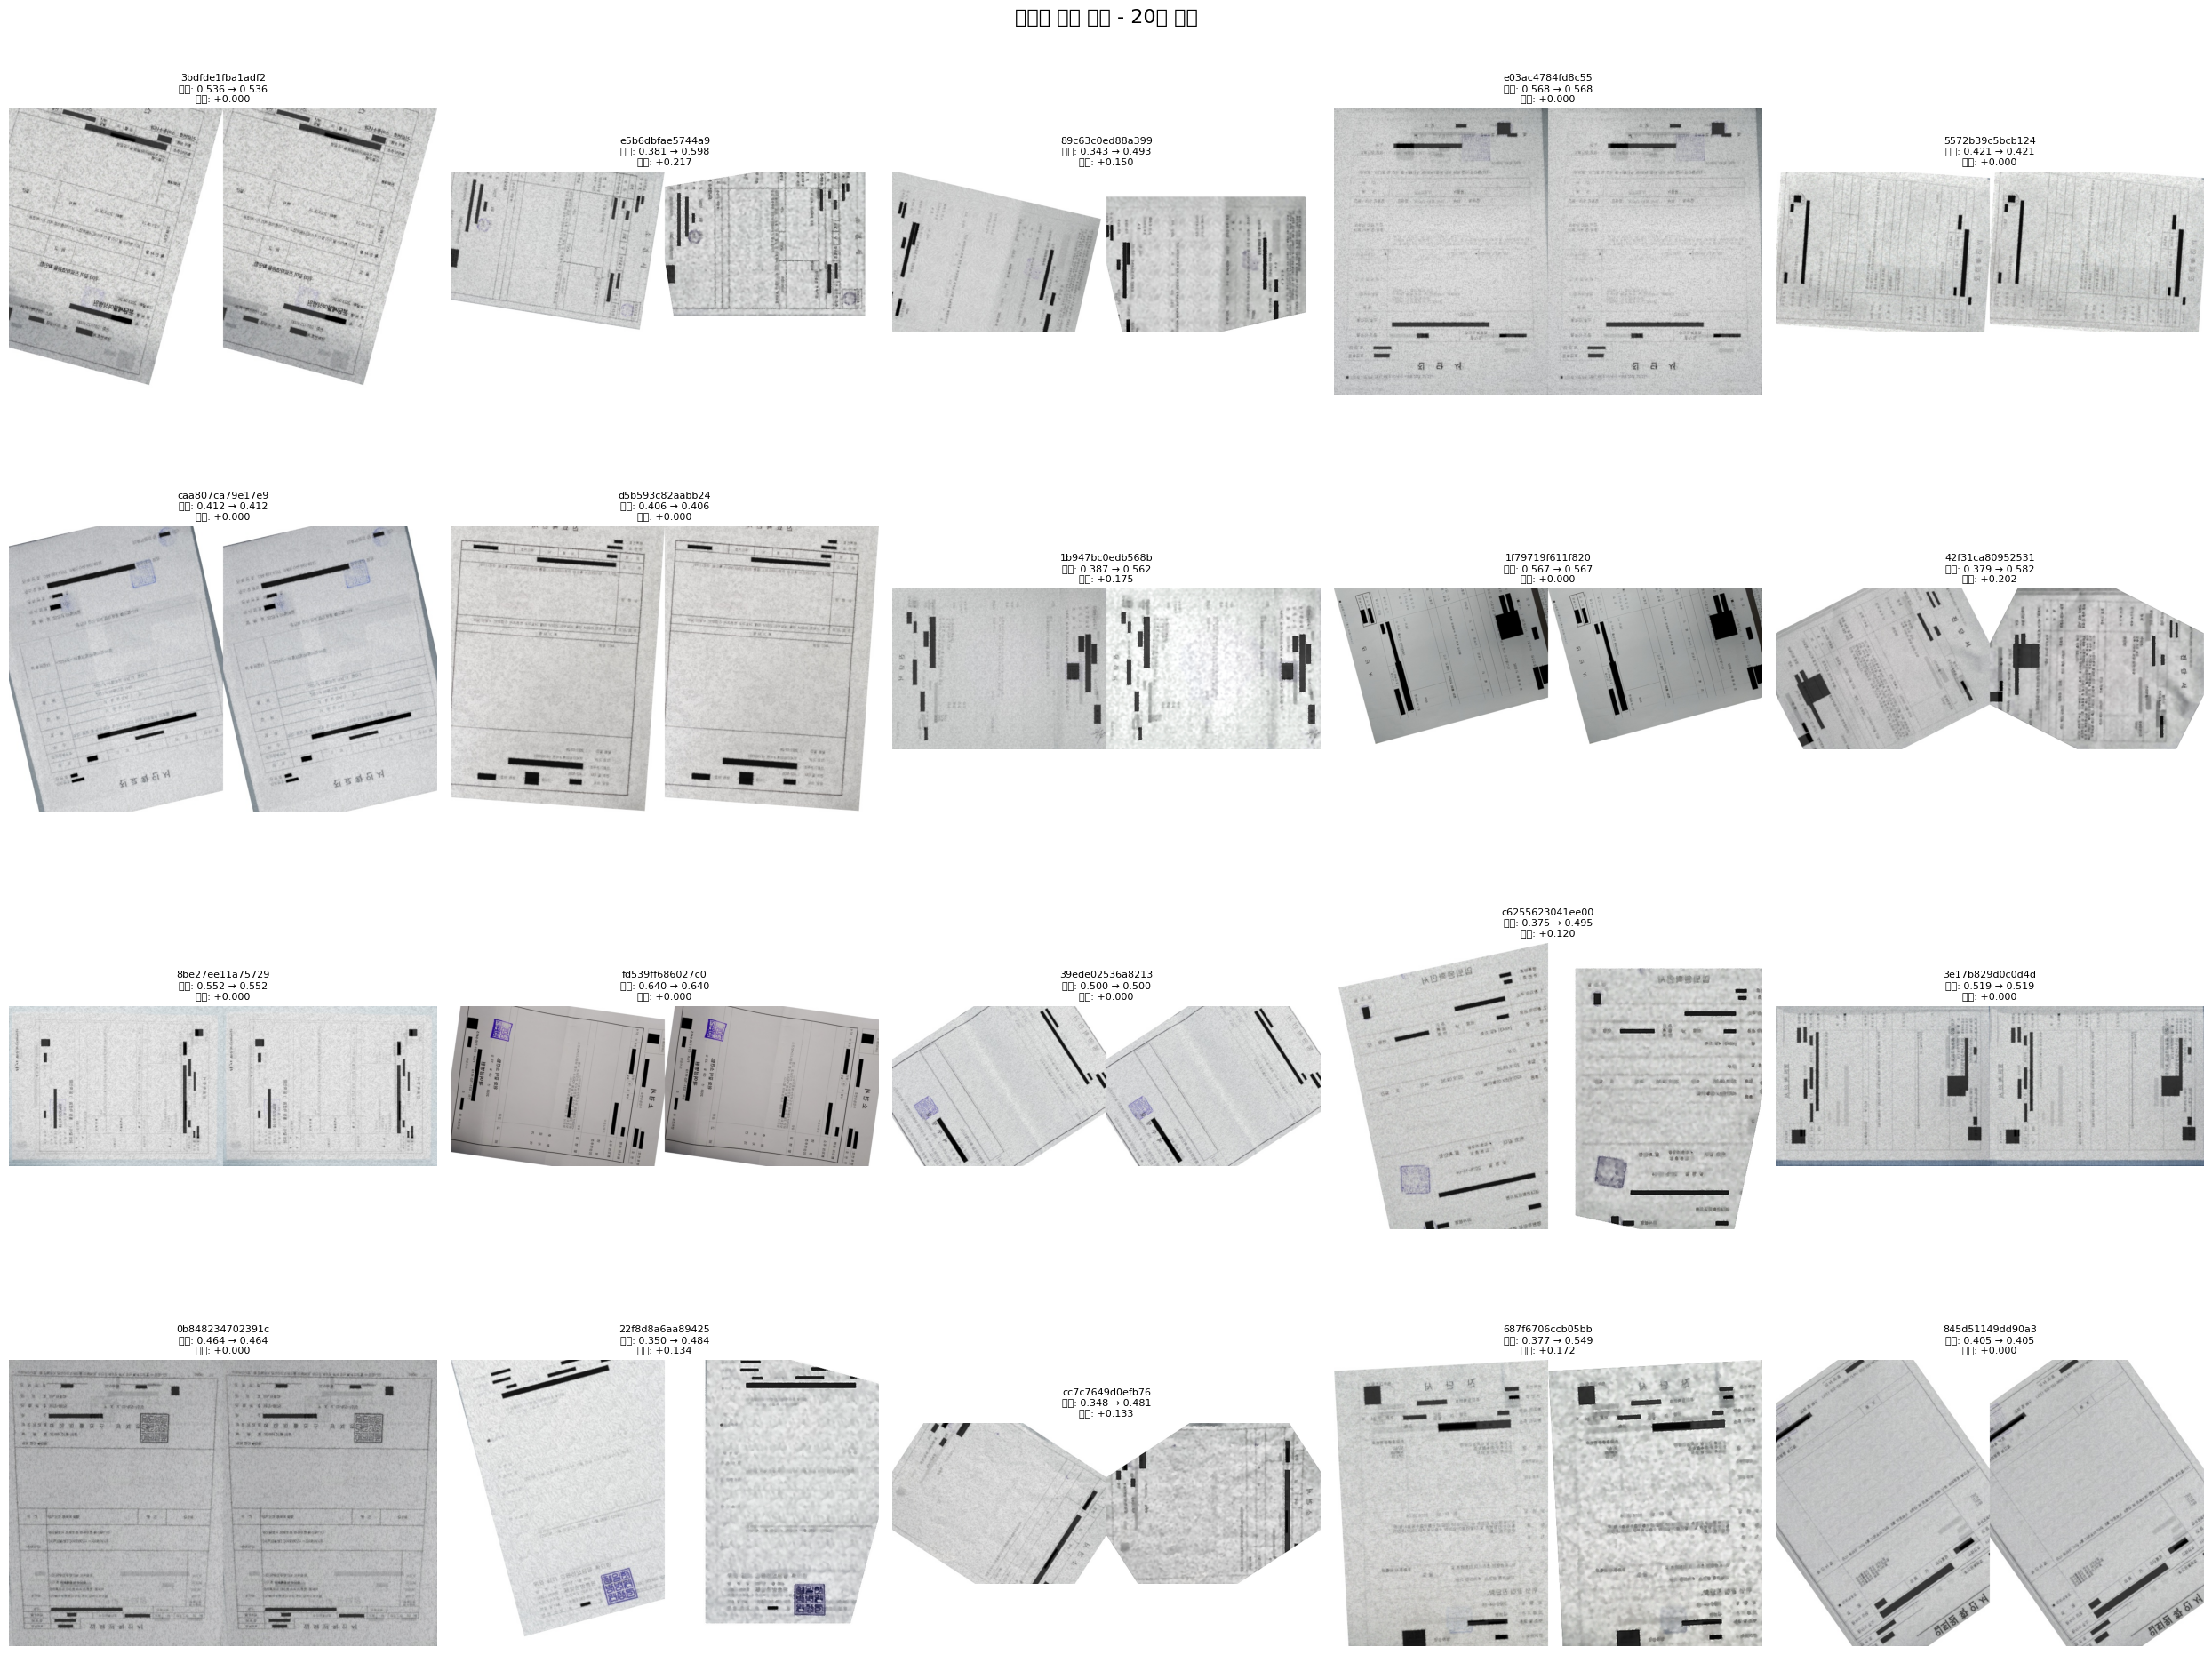


2️⃣ 품질 개선 수치 분석 진행중...

품질 개선 분석 결과
📊 전체 샘플 수: 20개
📈 평균 품질 개선: +0.065
📈 품질 향상 이미지: 8개 (40.0%)
📈 유의미한 개선 (5%+): 8개 (40.0%)

📊 원본 품질 점수: 0.447 ± 0.087
📊 전처리 후 품질: 0.512 ± 0.066

📋 개선 효과별 분류:
   🌟 뛰어남 (10%+): 8개
   ✅ 양호 (5-10%): 0개
   📊 보통 (2-5%): 0개
   📉 미미 (0-2%): 0개
   ❌ 효과없음/악화: 12개

🏆 최고 개선 사례:
   파일: e5b6dbfae5744a9f.jpg
   품질: 0.381 → 0.598
   개선: +0.217 (+56.9%)

🎯 결론:
   ✅ 전처리 효과 뛰어남 - 실제 추론에 적용 권장

3️⃣ 최종 효과 판정
📊 판정 결과: 🌟 전처리 적용 강력 권장
🎯 권장 조치: inf_new.ipynb에 전처리 로직 통합 후 전체 추론 실행
🔍 신뢰도: 높음

📈 상세 지표:
   • 평균 품질 개선: +0.065
   • 개선된 이미지 비율: 40.0%
   • 유의미한 개선 비율: 40.0%
   • 뛰어난 개선 사례: 8개

🚀 다음 단계:
   1. inf_new.ipynb 코드에 전처리 함수 통합
   2. TTAImageDataset.__getitem__에 adaptive_preprocessing 추가
   3. 전체 3140개 이미지로 추론 실행
   4. 제출 점수 비교 (전처리 전 vs 후)


In [50]:
# 전처리 효과 검증 실행
validation_results = test_preprocessing_effects(selected_images)

In [20]:
# =============================================================================
# STEP 6: 수동 라벨링 인터페이스
# =============================================================================

def display_images_grid(image_list, start_idx=0, grid_size=10):
    """이미지를 5x2 격자로 출력"""
    fig, axes = plt.subplots(2, 5, figsize=(30, 12))
    fig.suptitle(f'Images {start_idx+1}-{start_idx+grid_size}', fontsize=16)
    
    for i in range(grid_size):
        row = i // 5
        col = i % 5
        
        if start_idx + i < len(image_list):
            img_info = image_list[start_idx + i]
            img_path = os.path.join(TEST_PATH, img_info['filename'])
            
            try:
                img = Image.open(img_path)
                axes[row, col].imshow(img)
                axes[row, col].set_title(f"{start_idx+i+1}: {img_info['filename']}\n"
                                       f"예측: {img_info['predicted_class']} "
                                       f"(신뢰도: {img_info['confidence']:.2f})\n"
                                       f"품질: {img_info['quality_score']:.3f}",
                                       fontsize=10)
            except Exception as e:
                axes[row, col].text(0.5, 0.5, f"Error\n{e}", ha='center', va='center')
        else:
            axes[row, col].set_visible(False)
        
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

In [12]:
def manual_labeling_interface(selected_images, start_idx=0):
    """수동 라벨링 인터페이스"""
    print("\n🎯 수동 라벨링 시작!")
    print("=" * 50)
    print("📋 클래스 정보 (참고용):")
    for idx, row in meta_df.iterrows():
        print(f"  {row['target']:2d}: {row['class_name']}")
    print("=" * 50)
    
    # 결과 저장용 리스트
    manual_labels = []
    
    # 이전 작업 로드 (있다면)
    progress_file = 'labeling_progress.csv'
    if os.path.exists(progress_file):
        print(f"📂 이전 작업 진행상황 로드: {progress_file}")
        prev_df = pd.read_csv(progress_file)
        manual_labels = prev_df.to_dict('records')
        start_idx = len(manual_labels)
        print(f"   이전 작업: {len(manual_labels)}장 완료")
    
    current_idx = start_idx
    
    while current_idx < len(selected_images):
        # 10장씩 보여주기
        display_images_grid(selected_images, current_idx, min(10, len(selected_images) - current_idx))
        
        # 각 이미지에 대해 라벨 입력받기
        batch_end = min(current_idx + 10, len(selected_images))
        for i in range(current_idx, batch_end):
            img_info = selected_images[i]
            print(f"\n[{i+1}/{len(selected_images)}] {img_info['filename']}")
            print(f"  예측클래스: {img_info['predicted_class']}, 품질점수: {img_info['quality_score']:.3f}")
            
            while True:
                try:
                    user_input = input(f"  정답 클래스 입력 (0-16, s=건너뛰기, q=종료): ").strip()
                    
                    if user_input.lower() == 'q':
                        print("🛑 라벨링 중단")
                        return manual_labels
                    elif user_input.lower() == 's':
                        print("  ⏭️  건너뛰기")
                        break
                    else:
                        label = int(user_input)
                        if 0 <= label <= 16:
                            manual_labels.append({
                                'filename': img_info['filename'],
                                'true_label': label,
                                'predicted_class': img_info['predicted_class'],
                                'quality_score': img_info['quality_score']
                            })
                            print(f"  ✅ 라벨 {label} 저장")
                            break
                        else:
                            print("  ❌ 0-16 범위의 숫자를 입력하세요")
                except ValueError:
                    print("  ❌ 올바른 숫자를 입력하세요")
        
        current_idx = batch_end
        
        # 중간 저장 (50장마다)
        if len(manual_labels) % 50 == 0 and len(manual_labels) > 0:
            temp_df = pd.DataFrame(manual_labels)
            temp_df.to_csv(progress_file, index=False)
            print(f"💾 진행상황 저장: {len(manual_labels)}장 완료")
        
        # 계속할지 확인
        if current_idx < len(selected_images):
            continue_input = input(f"\n계속 진행하시겠습니까? (y/n, 현재 {len(manual_labels)}장 완료): ")
            if continue_input.lower() != 'y':
                break
    
    return manual_labels

In [ ]:
# =============================================================================
# STEP 7: 최종 GT 파일 생성
# =============================================================================

def save_final_gt(manual_labels):
    """최종 GT 파일 생성 및 검증"""
    print(f"\n💾 최종 GT 파일 생성 중... (총 {len(manual_labels)}장)")
    
    # 데이터프레임 생성
    gt_df = pd.DataFrame(manual_labels)
    
    # 파일명에서 ID 추출 (확장자 제거)
    gt_df['ID'] = gt_df['filename'].str.replace('.jpg', '')
    
    # 최종 GT 형식으로 변환
    final_gt = gt_df[['ID', 'true_label']].copy()
    final_gt.columns = ['ID', 'target']
    
    # GT 파일 저장
    final_gt.to_csv('mini_gt_500.csv', index=False)
    
    # 백업 저장
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_filename = f'mini_gt_500_backup_{timestamp}.csv'
    final_gt.to_csv(backup_filename, index=False)
    
    # 통계 출력
    print("📊 최종 GT 통계:")
    print(f"   총 라벨링된 이미지: {len(final_gt)}장")
    print("\n   클래스별 분포:")
    class_counts = final_gt['target'].value_counts().sort_index()
    for class_id, count in class_counts.items():
        class_name = meta_df[meta_df['target'] == class_id]['class_name'].iloc[0]
        print(f"     {class_id:2d} ({class_name}): {count:3d}장")
    
    # 품질점수 분포
    if 'quality_score' in gt_df.columns:
        print(f"\n   품질점수 분포:")
        print(f"     평균: {gt_df['quality_score'].mean():.3f}")
        print(f"     범위: {gt_df['quality_score'].min():.3f} ~ {gt_df['quality_score'].max():.3f}")
    
    print(f"\n✅ GT 파일 저장 완료:")
    print(f"   📁 main: mini_gt_500.csv")
    print(f"   📁 backup: {backup_filename}")
    
    return final_gt

In [ ]:
# =============================================================================
# 실행 가이드
# =============================================================================

print("\n" + "="*60)
print("🎯 수동 라벨링 실행 가이드")
print("="*60)
print("1️⃣  manual_labels = manual_labeling_interface(selected_images)")
print("2️⃣  final_gt = save_final_gt(manual_labels)")
print("3️⃣  팀원과 작업 분담 시: 리스트를 절반으로 나누어 진행")
print("4️⃣  완료 후: mini_gt_500.csv 파일을 다음 단계에서 사용")
print("="*60)

In [ ]:
# GT 작업 시작
manual_labels = manual_labeling_interface(selected_images, start_idx=0)

In [ ]:
# GT 작업 세이브
final_gt = save_final_gt(manual_labels)